In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import os
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils import compute_class_weight
import matplotlib.pyplot as plt
from collections import Counter
import gc
from keras import backend
from keras.metrics import Recall, Accuracy
import graphviz
import pydot

In [73]:
data = []
for filename in os.listdir("Cropped/UTKFace"):
    if filename.endswith(".jpg"):
        row_data = [os.path.join("Cropped/UTKFace", filename)]
        filename = filename.split("_")
        if len(filename) > 3:
            row_data.append(filename[2]) # 3rd integer represents race
            data.append(row_data)

In [74]:
df_image = pd.DataFrame(data, columns = ["filename", "Race"])

df_image = df_image[df_image["Race"] != "4"]
# df_image["Race"] = df_image["Race"].map({
#     "0":"White",
#     "1":"Black",
#     "2":"Asian",
#     "3":"Indian"

# })

train, test = train_test_split(df_image, stratify = df_image["Race"], test_size=0.2)


In [75]:
df_image["Race"].value_counts(normalize=True)

Race
0    0.457820
1    0.205606
3    0.180575
2    0.155999
Name: proportion, dtype: float64

In [76]:
# compute_class_weight(
#     "balanced", 
#     classes = np.array(["White", "Black", "Indian", "Asian"]),
#     y = df_image["Race"])


In [77]:
skf = StratifiedKFold(n_splits = 5, shuffle=True)
train_scores = []
val_scores = []
per_class_scores = []

for fold, (train_index, val_index) in enumerate(list(skf.split(X = df_image["filename"], y = df_image["Race"]))):
    backend.clear_session()
    gc.collect()


    train_df = df_image.iloc[train_index]
    validation_df = df_image.iloc[val_index]

    train = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,
                                                        fill_mode="nearest").flow_from_dataframe(
    dataframe = train_df,
    x_col = "filename",
    y_col = "Race",
    class_mode = "categorical",
    target_size = (200, 200),
        )
    test = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255).flow_from_dataframe(
    dataframe = validation_df,
    x_col = "filename",
    y_col = "Race",
    class_mode = "categorical",
    fill_mode = "nearest",
    target_size=(200, 200),
    shuffle = False)

    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(200, 200, 3)))
    model.add(keras.layers.Dense(512, activation = "relu"))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(256, activation = "relu"))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(128, activation = "relu"))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(4, activation = "softmax"))
    model.compile(loss = "CategoricalCrossentropy", metrics = ["accuracy",
                                                               Recall(class_id = 0, name = "recall_race_0", thresholds = 0.3),
                                                               Recall(class_id = 1, name = "recall_race_1", thresholds = 0.3),
                                                               Recall(class_id = 2, name = "recall_race_2", thresholds = 0.3),
                                                               Recall(class_id = 3, name = "recall_race_3", thresholds = 0.3)], optimizer=keras.optimizers.Adam())
    history = model.fit(train,
            class_weight={0:0.54606569 , 1:1.21591913, 2:1.60257717, 3:1.38446541},
            validation_data = test,
            epochs = 15)

    test.reset()
    validation_predictions = np.argmax(model.predict(test), axis = -1)
    validation_true = np.array(test.classes)
    train_scores.append(history.history["accuracy"])
    val_scores.append(history.history["val_accuracy"])

    accuracy_per_class_temp = {}

    # class_dict = dict(Counter(test.classes))
    # for index, total in class_dict.items():
    #     class_predict = validation_predictions[validation_true == index]
    #     class_true = validation_true[validation_true == index]
    #     correct_predictions = np.sum(class_predict == class_true)


    #     percent_correct = (correct_predictions / total) * 100

    #     accuracy_per_class_temp[index] = percent_correct

    # print(per_class_scores)

    accuracy_per_class_temp[0] = history.history["val_recall_race_0"]
    accuracy_per_class_temp[1] = history.history["val_recall_race_1"]
    accuracy_per_class_temp[2] = history.history["val_recall_race_2"]
    accuracy_per_class_temp[3] = history.history["val_recall_race_3"]

    accuracy_per_class_temp[4] = history.history["recall_race_0"]
    accuracy_per_class_temp[5] = history.history["recall_race_1"]
    accuracy_per_class_temp[6] = history.history["recall_race_2"]
    accuracy_per_class_temp[7] = history.history["recall_race_3"]
    
    print(accuracy_per_class_temp)
    per_class_scores.append(accuracy_per_class_temp)


    per_fold_train = np.mean(train_scores, axis = 0)
    print(per_fold_train)
    per_fold_validation = np.mean(val_scores, axis = 0)
    print(per_fold_validation)



Found 17610 validated image filenames belonging to 4 classes.
Found 4403 validated image filenames belonging to 4 classes.
Epoch 1/15
551/551 [==============================] - 15s 26ms/step - loss: 4.7353 - accuracy: 0.2098 - recall_race_0: 0.0391 - recall_race_1: 0.0359 - recall_race_2: 0.0422 - recall_race_3: 0.0333 - val_loss: 1.3857 - val_accuracy: 0.1806 - val_recall_race_0: 0.0000e+00 - val_recall_race_1: 0.0000e+00 - val_recall_race_2: 0.0000e+00 - val_recall_race_3: 0.0000e+00
Epoch 2/15
551/551 [==============================] - 14s 26ms/step - loss: 1.3909 - accuracy: 0.2918 - recall_race_0: 4.9615e-04 - recall_race_1: 0.0014 - recall_race_2: 3.6403e-04 - recall_race_3: 3.1447e-04 - val_loss: 1.3848 - val_accuracy: 0.1806 - val_recall_race_0: 0.0000e+00 - val_recall_race_1: 0.0000e+00 - val_recall_race_2: 0.0000e+00 - val_recall_race_3: 0.0000e+00
Epoch 3/15
551/551 [==============================] - 14s 26ms/step - loss: 1.3869 - accuracy: 0.2546 - recall_race_0: 2.4808e-04

KeyboardInterrupt: 

In [78]:
per_fold_train

array([0.2024418 , 0.19159569, 0.24281658, 0.2132879 , 0.21550256,
       0.22061329, 0.29318568, 0.23180011, 0.20829074, 0.19222033,
       0.25877342, 0.2483816 , 0.23003975, 0.30289608, 0.2177172 ])

In [ ]:
class_data = pd.DataFrame({"class" : per_class_scores}) 
class_data.to_csv(r"C:\Users\Allen\Desktop\Coding\CSC 466\class_scores_for_mlp.csv")

In [ ]:
fold_data = pd.DataFrame({"Train": per_fold_train, "Validation": per_fold_validation}) 
fold_data.to_csv(r"C:\Users\Allen\Desktop\Coding\CSC 466\train_validation_for_mlp.csv")

In [ ]:
model.save("mlp_model.keras")

In [79]:
skf = StratifiedKFold(n_splits = 5, shuffle=True)
train_scores = []
val_scores = []
per_class_scores = []

for fold, (train_index, val_index) in enumerate(list(skf.split(X = df_image["filename"], y = df_image["Race"]))):
    backend.clear_session()
    gc.collect()


    train_df = df_image.iloc[train_index]
    validation_df = df_image.iloc[val_index]

    train = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,
                                                        fill_mode="nearest").flow_from_dataframe(
    dataframe = train_df,
    x_col = "filename",
    y_col = "Race",
    class_mode = "categorical",
    target_size = (200, 200),
        )
    test = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255).flow_from_dataframe(
    dataframe = validation_df,
    x_col = "filename",
    y_col = "Race",
    class_mode = "categorical",
    fill_mode = "nearest",
    target_size=(200, 200),
    shuffle = False)

    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (5, 5), padding = "same", input_shape=(200, 200, 3), activation = "relu"))
    model.add(keras.layers.Conv2D(32, (5, 5), padding = "same", activation = "relu"))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(64, (3, 3), padding = "same", activation = "relu"))
    model.add(keras.layers.Conv2D(64, (3, 3), padding = "same", activation = "relu"))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(128, (3, 3), padding = "same", activation = "relu"))
    model.add(keras.layers.Conv2D(128, (3, 3), padding = "same", activation = "relu"))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation = "relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(4, activation = "softmax"))

    model.compile(loss = "CategoricalCrossentropy", metrics = ["accuracy",
                                                               Recall(class_id = 0, name = "recall_race_0"),
                                                               Recall(class_id = 1, name = "recall_race_1"),
                                                               Recall(class_id = 2, name = "recall_race_2"),
                                                               Recall(class_id = 3, name = "recall_race_3")], optimizer=keras.optimizers.Adam())
    history = model.fit(train,
            validation_data = test,
            class_weight={0:0.54606569, 1:1.21591913 , 2:1.60257717, 3:1.38446541},
            batch_size = 64,
            epochs = 20)

    test.reset()
    validation_predictions = np.argmax(model.predict(test), axis = -1)
    validation_true = np.array(test.classes)
    train_scores.append(history.history["accuracy"])
    val_scores.append(history.history["val_accuracy"])

    accuracy_per_class_temp = {}

    # class_dict = dict(Counter(test.classes))
    # for index, total in class_dict.items():
    #     class_predict = validation_predictions[validation_true == index]
    #     class_true = validation_true[validation_true == index]
    #     correct_predictions = np.sum(class_predict == class_true)
    #     percent_correct = (correct_predictions / total) * 100

    #     accuracy_per_class_temp[index] = percent_correct

    accuracy_per_class_temp[0] = history.history["val_recall_race_0"]
    accuracy_per_class_temp[1] = history.history["val_recall_race_1"]
    accuracy_per_class_temp[2] = history.history["val_recall_race_2"]
    accuracy_per_class_temp[3] = history.history["val_recall_race_3"]

    accuracy_per_class_temp[4] = history.history["recall_race_0"]
    accuracy_per_class_temp[5] = history.history["recall_race_1"]
    accuracy_per_class_temp[6] = history.history["recall_race_2"]
    accuracy_per_class_temp[7] = history.history["recall_race_3"]


    per_class_scores.append(accuracy_per_class_temp)

    print(per_class_scores)

    per_fold_train = np.mean(train_scores, axis = 0)
    print(per_fold_train)
    per_fold_validation = np.mean(val_scores, axis = 0)
    print(per_fold_validation)



Found 17610 validated image filenames belonging to 4 classes.
Found 4403 validated image filenames belonging to 4 classes.
Epoch 1/20
551/551 [==============================] - 65s 117ms/step - loss: 1.3244 - accuracy: 0.4207 - recall_race_0: 0.1328 - recall_race_1: 0.3991 - recall_race_2: 0.3895 - recall_race_3: 0.0434 - val_loss: 0.9181 - val_accuracy: 0.6511 - val_recall_race_0: 0.4722 - val_recall_race_1: 0.4895 - val_recall_race_2: 0.7322 - val_recall_race_3: 0.3283
Epoch 2/20
551/551 [==============================] - 60s 108ms/step - loss: 0.9049 - accuracy: 0.5996 - recall_race_0: 0.4237 - recall_race_1: 0.6333 - recall_race_2: 0.5657 - recall_race_3: 0.3239 - val_loss: 0.6617 - val_accuracy: 0.7470 - val_recall_race_0: 0.8760 - val_recall_race_1: 0.6740 - val_recall_race_2: 0.5968 - val_recall_race_3: 0.2302
Epoch 3/20
551/551 [==============================] - 59s 108ms/step - loss: 0.6935 - accuracy: 0.6782 - recall_race_0: 0.4908 - recall_race_1: 0.7352 - recall_race_2: 0.7

In [81]:
class_data = pd.DataFrame({"class" : per_class_scores}) 
class_data.to_csv(r"C:\Users\Allen\Desktop\Coding\CSC 466\class_scores_for_cnn.csv")

In [ ]:
fold_data = pd.DataFrame({"Train": per_fold_train, "Validation": per_fold_validation}) 
fold_data.to_csv(r"C:\Users\Allen\Desktop\Coding\CSC 466\train_validation_for_cnn.csv")

In [ ]:
model.save("cnn_model")

INFO:tensorflow:Assets written to: cnn_model\assets


INFO:tensorflow:Assets written to: cnn_model\assets


In [ ]:
img = Image.open(
    r"C:\Users\Allen\Downloads\IMG_0791.jpg"
)

img = img.resize((200, 200))
img_array = keras.utils.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)
predicted = model.predict(img_array)
# print(np.argmax(predicted, axis = 1)[0])
print(predicted)

1/1 [==============================] - 0s 16ms/step
[[9.9998045e-01 1.5736923e-10 1.3597108e-10 1.9519108e-05]]


In [ ]:
import tensorflow as tf
import keras as keras
model = tf.keras.models.load_model(r"C:\Users\Allen\Desktop\Coding\CSC 466\FacialRecognitionRacialBias\cnn_model.keras")

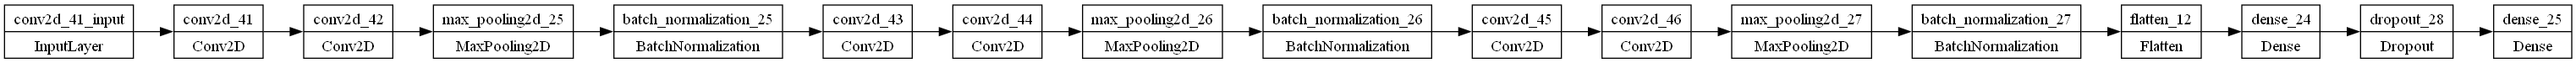

In [ ]:
tf.keras.utils.plot_model(model, to_file = r"C:\Users\Allen\Desktop\Coding\CSC 466\model_cnn.png", expand_nested = True,
                          rankdir = "LR")

In [ ]:
model.save("cnn_model.keras")

In [90]:
for i in per_class_scores:
    print(i)

{0: [0.4722222089767456, 0.8759920597076416, 0.7996031641960144, 0.7415674328804016, 0.6805555820465088, 0.858134925365448, 0.8159722089767456, 0.8665674328804016, 0.7127976417541504, 0.7648809552192688, 0.7911706566810608, 0.901289701461792, 0.8055555820465088, 0.7936508059501648, 0.8164682388305664, 0.7807539701461792, 0.870039701461792, 0.7777777910232544, 0.8139880895614624, 0.8353174328804016], 1: [0.48950275778770447, 0.6740331649780273, 0.819889485836029, 0.6563535928726196, 0.7635359168052673, 0.7690607905387878, 0.9049723744392395, 0.7845304012298584, 0.8585635423660278, 0.759115993976593, 0.8850829005241394, 0.7657458782196045, 0.7359116077423096, 0.6353591084480286, 0.859668493270874, 0.7679557800292969, 0.8265193104743958, 0.8486188054084778, 0.7502762675285339, 0.7679557800292969], 2: [0.7321688532829285, 0.5967976450920105, 0.7554585337638855, 0.8922852873802185, 0.8544396162033081, 0.7831149697303772, 0.8180494904518127, 0.751091718673706, 0.8544396162033081, 0.820960700

In [130]:
recall_scores_val = {i: [] for i in range(4)}
recall_scores_train = {i: [] for i in range(4)}

In [131]:
for fold_scores in per_class_scores:
    recall_scores_val[0].append(fold_scores[0])
    recall_scores_val[1].append(fold_scores[1])
    recall_scores_val[2].append(fold_scores[2])
    recall_scores_val[3].append(fold_scores[3])
    recall_scores_train[0].append(fold_scores[4])
    recall_scores_train[1].append(fold_scores[5])
    recall_scores_train[2].append(fold_scores[6])
    recall_scores_train[3].append(fold_scores[7])

In [95]:
average_recall_scores_val = {}
average_recall_scores_train = {}

In [96]:
for i in range(4):
    scores = np.array(recall_scores_val[i])
    average_recall_scores_val[i] = np.mean(scores, axis = 0)

In [98]:
for i in range(4):
    scores = np.array(recall_scores_train[i])
    average_recall_scores_train[i] = np.mean(scores, axis = 0)

In [124]:
recall_train = pd.DataFrame.from_dict(average_recall_scores_train, orient = "index").T
recall_train.columns = ["White", "Black", "Asian", "Indian"]
recall_train = recall_train * 100

recall_val = pd.DataFrame.from_dict(average_recall_scores_val, orient = "index").T
recall_val.columns = ["White", "Black", "Asian", "Indian"]
recall_val = recall_val * 100



<Axes: title={'center': 'Training % Correct by Race for CNN (5-fold CV)'}>

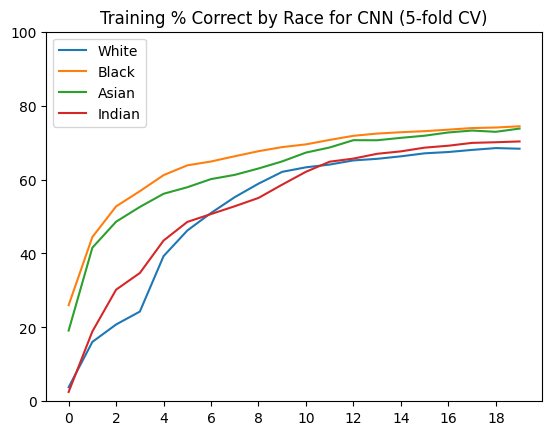

In [125]:
recall_train.plot(xticks = list(range(0, 20, 2)), ylim = (0, 100),
                  title = "Training % Correct by Race for CNN (5-fold CV)")

<Axes: title={'center': 'Validation % Correct by Race for CNN (5-fold CV)'}>

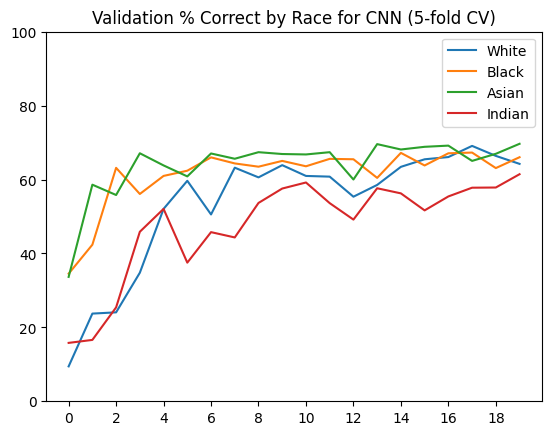

In [126]:
recall_val.plot(xticks = list(range(0, 20, 2)), ylim = (0, 100),
                  title = "Validation % Correct by Race for CNN (5-fold CV)")

In [9]:
model = tf.keras.models.load_model(r"C:\Users\Allen\Desktop\Coding\CSC 466\FacialRecognitionRacialBias\cnn_model.keras")
img = Image.open(
    r"C:\Users\Allen\Downloads\IMG_0792.jpg"
)

img = img.resize((200, 200))
img_array = keras.utils.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)
predicted = model.predict(img_array)
print(np.argmax(predicted, axis = 1)[0])
print(predicted)

1/1 [==============================] - 0s 108ms/step
3
[[1.3144992e-13 3.5310908e-25 1.4735275e-26 1.0000000e+00]]
